In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import calendar
from utils import *
import quantstats as qs

In [2]:
# TODO
# Validate growth rate calculations

The entire date range is from 2019-12-27 00:00:00 to 2023-10-31 00:00:00 (1404 days 00:00:00)


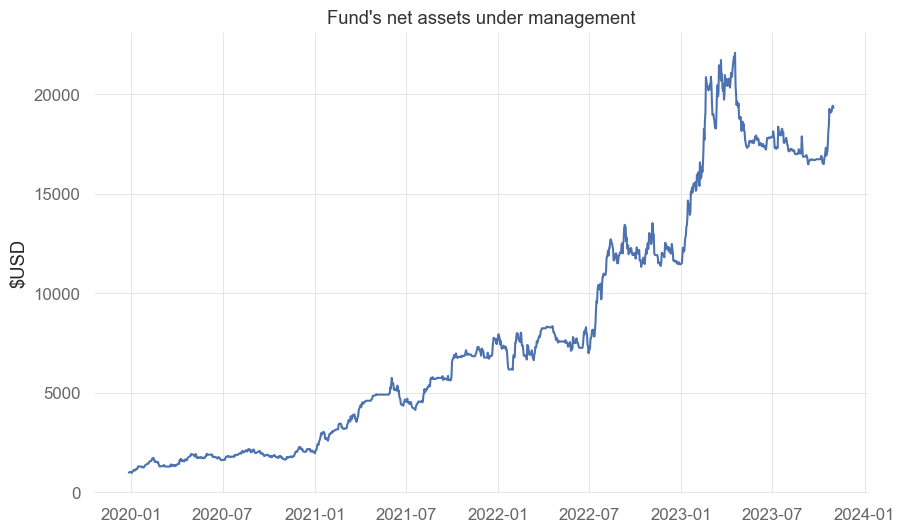

In [3]:
# Data and super variables
# Import the data for fund 1
f1_DailyAuM = pd.read_csv("./Data/Daily AuM - AuM (1).csv")
f1_DailyTrades = pd.read_csv("./Data/Daily AuM - Trades_10.csv")


# Get the union of both datasets (Date-wise)
f1_DailyAuM.Date = pd.to_datetime(f1_DailyAuM.Date, dayfirst = True, format = "mixed")
f1_DailyTrades.buy_date = pd.to_datetime(f1_DailyTrades.buy_date, dayfirst = True, format = "mixed")
f1_DailyTrades.sell_date = pd.to_datetime(f1_DailyTrades.sell_date, dayfirst = True, format = "mixed")

f1_DailyTrades_LastDate = f1_DailyTrades.iloc[-1].sell_date
f1_DailyAuM_LastDate = f1_DailyAuM.iloc[-1].Date

if f1_DailyTrades_LastDate < f1_DailyAuM_LastDate:
    f1_DailyAuM = f1_DailyAuM[f1_DailyAuM.Date <= f1_DailyTrades_LastDate]
else:
    f1_DailyTrades = f1_DailyTrades[f1_DailyTrades.sell_date <= f1_DailyAuM_LastDate]

# start and end of date of the entire dataset
START_DATE, END_DATE = f1_DailyAuM.iloc[0].Date, f1_DailyAuM.iloc[-1].Date 
START_MONTH, END_MONTH = f1_DailyAuM.iloc[0].Date.month, f1_DailyAuM.iloc[-1].Date.month 
START_YEAR, END_YEAR = f1_DailyAuM.iloc[0].Date.year, f1_DailyAuM.iloc[-1].Date.year 



# Import BTC data as a benchmark
btcData = loadBTCReturn("./Data/Bitcoin-Historical-Data.csv")
btcData =  btcData[(START_DATE <= btcData.Date)&(btcData.Date <= END_DATE)].reset_index(drop=True)

# Import barclay hedge index as a benchmark
barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
barclayReturns = barclayReturns[(START_DATE <= barclayReturns.Date)&(barclayReturns.Date <= END_DATE)].reset_index(drop=True)

print(f"The entire date range is from {START_DATE} to {END_DATE} ({(f1_DailyAuM.iloc[-1].Date - f1_DailyAuM.iloc[0].Date)})")

plt.plot(f1_DailyAuM.Date, f1_DailyAuM.AuM); plt.title("Fund's net assets under management"); plt.ylabel("$USD"); plt.show()

Rolling growth rate


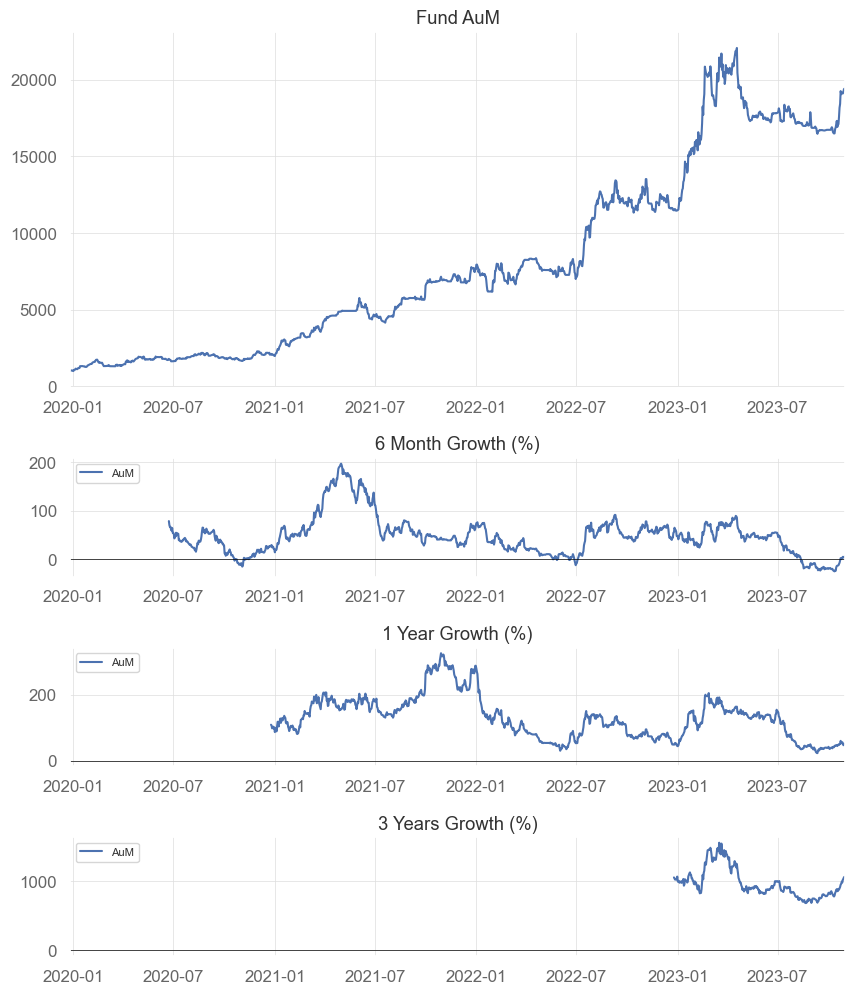

In [4]:
# Rolling growth rate
# Derived from growth rate formula in previous cell
print("Rolling growth rate")
return_6M = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 180)).dropna()
return_1Y = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 365)).dropna()
return_3Y = getRollingGrowth(f1_DailyAuM.set_index(["Date"]), datetime.timedelta(days = 365*3)).dropna()

subPlots = [return_6M,return_1Y,return_3Y]
plotTitle = ["Fund AuM", "6 Month Growth (%)", "1 Year Growth (%)", "3 Years Growth (%)"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [5]:
# Up/Down capture return
# Getting the monthly return of the Fund's AuM
print("Metric: Up/Down capture return (Relative to Barclay hedge index)")
for i in [[6, "months"]]: # , [1, "years"], [3, "years"]
    fundReturns = getMonthlyReturns(f1_DailyAuM)
    barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
    barclayReturns = barclayReturns[(START_DATE <= barclayReturns.Date)&(barclayReturns.Date <= END_DATE)].reset_index(drop=True)

    df = pd.concat([fundReturns.Date, fundReturns.fundReturn, barclayReturns.barclayReturn], axis = 1)
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Up capture
    upDf = dfCumulativeReturn[0 <= dfCumulativeReturn.barclayReturn]
    upCapture = calcCaptureRate(upDf[["fundReturn", "barclayReturn"]])
    # Down capture
    dnDf = dfCumulativeReturn[dfCumulativeReturn.barclayReturn <= 0]
    dnCapture = calcCaptureRate(dnDf[["fundReturn", "barclayReturn"]])

    print(f"{i[0]} {i[1]}:        up capture rate: {upCapture}   |    down capture rate: {dnCapture}")

Metric: Up/Down capture return (Relative to Barclay hedge index)
6 months:        up capture rate: 9.752609614561386   |    down capture rate: -7.2632011214009795


Metric: Rolling Up/Down capture return (Relative to BTC)


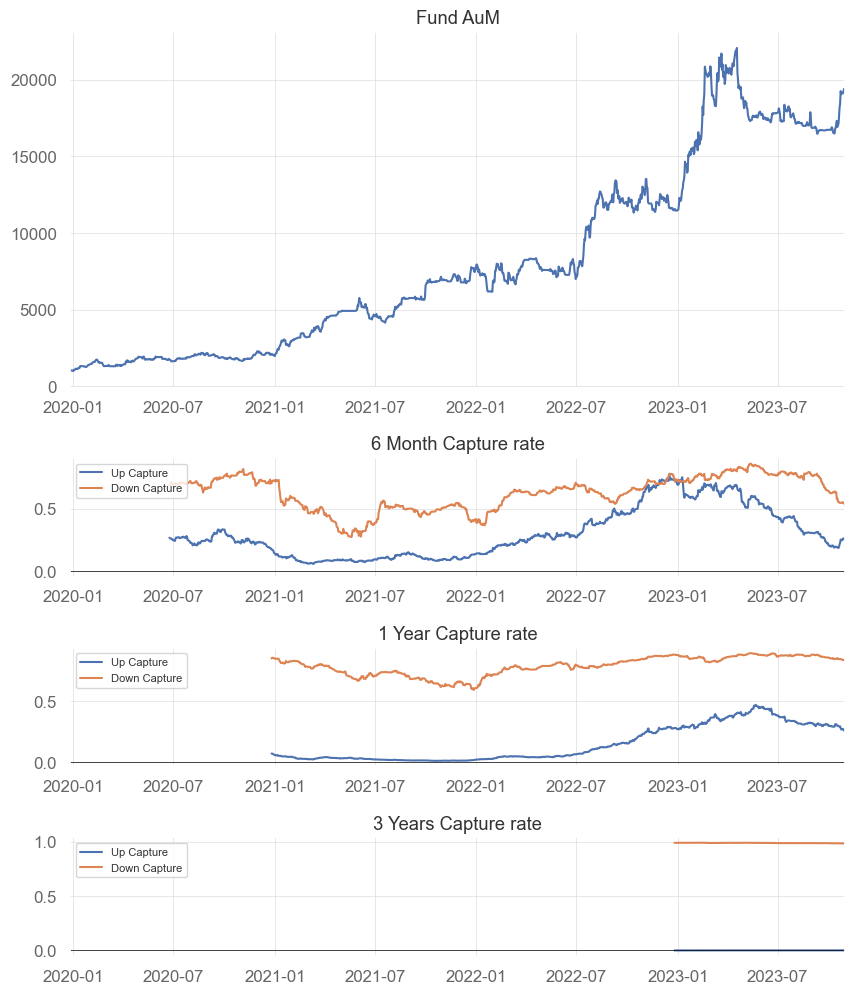

In [6]:
# Rolling up/Down capture ratio
print("Metric: Rolling Up/Down capture return (Relative to BTC)")

# Get the daily return of fund and BTC
df = pd.concat([f1_DailyAuM.Date, f1_DailyAuM.AuM, btcData.Price], axis = 1).set_index("Date")
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund", "Benchmark"]

upCapture_6M, downCapture_6M = calcRollingCaptureRate(dfReturn, datetime.timedelta(days = 180))
upCapture_1Y, downCapture_1Y = calcRollingCaptureRate(dfReturn, datetime.timedelta(days = 365))
upCapture_3Y, downCapture_3Y = calcRollingCaptureRate(dfReturn, datetime.timedelta(days = 365*3))

# process the results to feed them into plotter method
capture_6M = pd.concat([upCapture_6M.iloc[:,0],downCapture_6M.iloc[:,0]], axis = 1).dropna()
capture_6M.columns = ["Up Capture", "Down Capture"]

capture_1Y = pd.concat([upCapture_1Y.iloc[:,0],downCapture_1Y.iloc[:,0]], axis = 1).dropna()
capture_1Y.columns = ["Up Capture", "Down Capture"]

capture_3Y = pd.concat([upCapture_3Y.iloc[:,0],downCapture_3Y.iloc[:,0]], axis = 1).dropna()
capture_3Y.columns = ["Up Capture", "Down Capture"]

# Plot the rolling capture rate
subPlots = [capture_6M,capture_1Y,capture_3Y]
plotTitle = ["Fund AuM", "6 Month Capture rate", "1 Year Capture rate", "3 Years Capture rate"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [12]:
# Win rate
print("Metric: Win rate")
fundReturns = getMonthlyReturns(f1_DailyAuM).sort_values("Date", ascending=False)
tmp =fundReturns.iloc[0:6,:]
winrate = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"6 months win rate: {winrate}")

tmp =fundReturns.iloc[0:12,:]
winrate = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"1 year win rate: {winrate}")

tmp =fundReturns.iloc[0:36,:]
winrate = tmp[0<tmp.fundReturn].shape[0]/tmp.shape[0]
print(f"3 years win rate: {winrate}")

Metric: Win rate
6 months win rate: 0.3333333333333333
1 year win rate: 0.3333333333333333
3 years win rate: 0.6111111111111112


In [30]:
def calcRollingWinRate(df: pd.DataFrame, interval:datetime.timedelta):
    """
    Win rate refers to the probability of a fund being purchased at any time and held for a
    certain period of time before making a profit. For example, if a fund has been running
    for a year and has made profits in 9 months, the investment success rate of the fund is
    75%. This function calculates win ratio of dataframe df, in the required interval

    Args:
        df: pd.Dataframe: A dataframe containing the fund return on the first column
        interval: timedelta: The interval for the rolling calculation, use days, months
             or years as an argument
    
    Returns:
        A dataframe containing the rolling win rate for the end of specified date
    """
    def __internalFcn(__x):
        """
        Calculates win rate
        """
        __tmp = __x[0<__x].shape[0]/__x.shape[0]
        return __tmp

    dfOut = df.rolling(interval, min_periods = interval.days).apply(lambda x: __internalFcn(x))
    return dfOut

Metric: Rolling Win rate


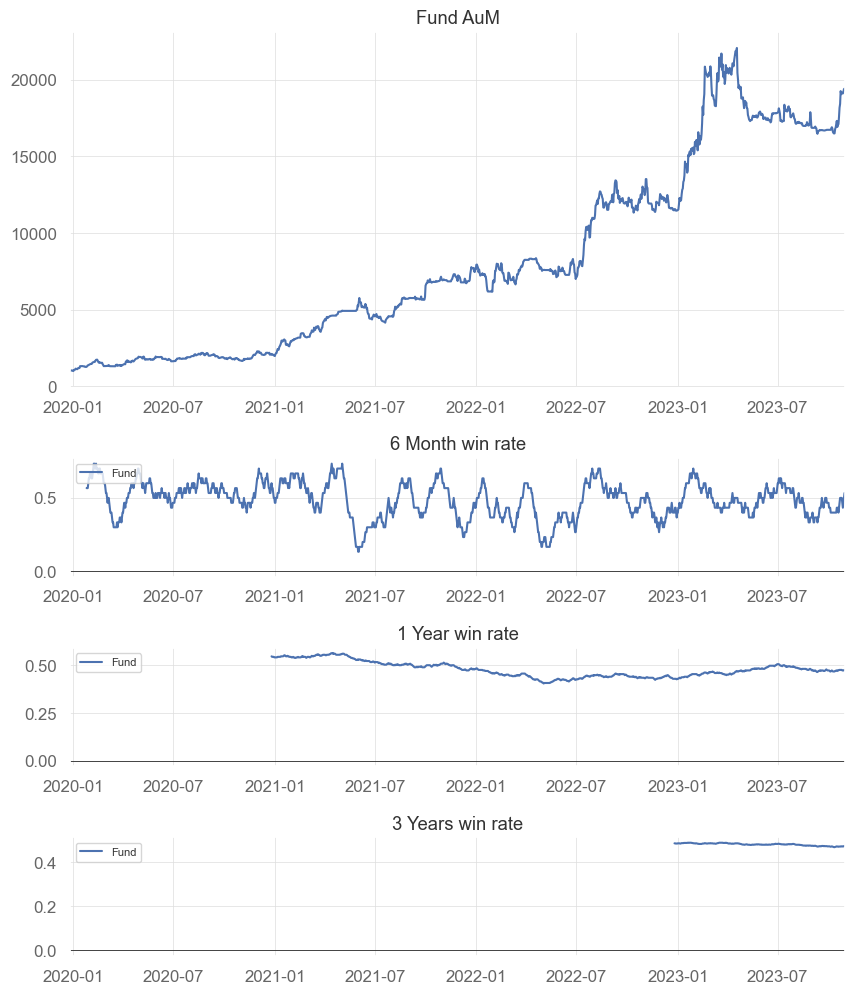

In [32]:
# Rolling win rate
# Get the daily return of fund and BTC
print("Metric: Rolling Win rate")

# Process the input data, only the fund AuM is required
df = f1_DailyAuM.set_index("Date")
dfReturn = df.pct_change(1).dropna()
dfReturn.columns = ["Fund"]

# Calculate the rolling win rates
winRate_6M = calcRollingWinRate(dfReturn, datetime.timedelta(30))
winRate_1Y = calcRollingWinRate(dfReturn, datetime.timedelta(365))
winRate_3Y = calcRollingWinRate(dfReturn, datetime.timedelta(365*3))

# Plot the rolling win rates
subPlots = [winRate_6M,winRate_1Y,winRate_3Y]
plotTitle = ["Fund AuM", "6 Month win rate", "1 Year win rate", "3 Years win rate"]
plotMainAndSubPlot(f1_DailyAuM.set_index(["Date"]), subPlots, plotTitle,True)

In [8]:
# Jensen's alpha
print("Metric: Jensen's alpha")
fundReturns = getMonthlyReturns(f1_DailyAuM)
fundReturns =  fundReturns[(START_DATE <= fundReturns.Date)&(fundReturns.Date <= END_DATE)].reset_index(drop=True)
barclayReturns = barclayHedgeIndex("./Data/Barclay_Hedge_Fund_Indexhistorical_data.xls")
barclayReturns = barclayReturns[(START_DATE <= barclayReturns.Date)&(barclayReturns.Date <= END_DATE)].reset_index(drop=True)
rfReturn = loadRiskFreeReturn("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv")
rfReturn = getMonthlyReturns(rfReturn[["Date","Price"]], ["Date", "rfReturn"])
rfReturn = rfReturn[(START_DATE <= rfReturn.Date)&(rfReturn.Date <= END_DATE)].reset_index(drop=True)

# Merge all data together 
df = pd.concat([fundReturns.Date, fundReturns.fundReturn, barclayReturns.barclayReturn, rfReturn.rfReturn], axis = 1)

# Run the code in a loop to get the results for 6months, 1 year and 3 years periods
tmp = pd.DataFrame(columns=["intervalStart","intervalEnd","fundReturn","barclayReturn","rfReturn","beta","jensenAlpha"])
for i in [[6, "months"], [1, "years"], [3, "years"]]:
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Calculate beta for each interval
    dfCumulativeReturn["beta"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        tempFund = fundReturns[(row.intervalStart<=fundReturns.Date)&(fundReturns.Date<=row.intervalEnd)]
        tempBenchmark = barclayReturns[(row.intervalStart<=barclayReturns.Date)&(barclayReturns.Date<=row.intervalEnd)]
        dfCumulativeReturn.iloc[i,-1] = calc_beta(tempFund.fundReturn, tempBenchmark.barclayReturn)

    # Calculate Jensen's alpha for each interval
    dfCumulativeReturn["jensenAlpha"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        alpha = calcJensenAlpha(row.fundReturn, row.barclayReturn, row.rfReturn, row.beta)
        dfCumulativeReturn.iloc[i,-1] = alpha
    
    tmp = pd.concat([tmp if not tmp.empty else None, dfCumulativeReturn])

tmp.index = ["6 months"]*7  + ["1 year"]*3 + ["3 years"]
tmp.style.set_caption("Jensen's alpha")

Metric: Jensen's alpha


,intervalStart,intervalEnd,fundReturn,barclayReturn,rfReturn,beta,jensenAlpha
6 months,2023-04-01 00:00:00,2023-09-30 00:00:00,-0.166019,0.030844,-0.020875,0.835919,-0.188377
6 months,2022-10-01 00:00:00,2023-03-31 00:00:00,0.652258,0.016570,0.355862,2.036242,0.987278
6 months,2022-04-01 00:00:00,2022-09-30 00:00:00,0.624562,-0.043082,1.087427,9.101785,9.826783
6 months,2021-10-01 00:00:00,2022-03-31 00:00:00,0.087364,-0.031520,1.203668,3.569241,3.292380
6 months,2021-04-01 00:00:00,2021-09-30 00:00:00,0.801733,0.059393,0.256576,9.002192,2.320234
6 months,2020-10-01 00:00:00,2021-03-31 00:00:00,0.534736,0.125019,1.610394,4.619064,5.785384
6 months,2020-04-01 00:00:00,2020-09-30 00:00:00,0.539160,0.055612,-0.740993,0.979671,0.499742
1 year,2022-10-01 00:00:00,2023-09-30 00:00:00,0.377952,0.047925,0.327558,1.694001,0.524093
1 year,2021-10-01 00:00:00,2022-09-30 00:00:00,0.766490,-0.073244,3.599997,7.099808,23.245800
1 year,2020-10-01 00:00:00,2021-09-30 00:00:00,1.765184,0.191837,2.280157,4.385595,8.643555


In [9]:
# Calmar ratio
print("Metric: Calmar ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM)

# Note, to use quanstats, the Date column has to be dataframe's index column
fundReturns =  fundReturns[(START_DATE <= fundReturns.Date)&(fundReturns.Date <= END_DATE)].reset_index(drop=True).set_index("Date")

# 6 months
calmar = qs.stats.calmar(fundReturns.iloc[-7:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

# 1 year
calmar = qs.stats.calmar(fundReturns.iloc[-13:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

# 3 years
calmar = qs.stats.calmar(fundReturns.iloc[-37:-1])
print(f"6 months calmar ratio: {calmar.iloc[0]}")

Metric: Calmar ratio
6 months calmar ratio: -1.597221101868814
6 months calmar ratio: 1.642781430337797
6 months calmar ratio: 3.4341676010729554


In [10]:
# Treynor ratio
print("Metric: Treynor ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM)
rfReturn = loadRiskFreeReturn("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv")
rfReturn = getMonthlyReturns(rfReturn[["Date","Price"]], ["Date", "rfReturn"])
rfReturn = rfReturn[(START_DATE <= rfReturn.Date)&(rfReturn.Date <= END_DATE)].reset_index(drop=True)

# Merge all data together 
df = pd.concat([fundReturns.Date, fundReturns.fundReturn, rfReturn.rfReturn], axis = 1)

# Run the code in a loop to get the results for 6months, 1 year and 3 years periods
tmp = pd.DataFrame(columns=["intervalStart","intervalEnd","fundReturn","barclayReturn","rfReturn","beta","TreynorRatio"])
for i in [[6, "months"], [1, "years"], [3, "years"]]:
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Calculate beta for each interval
    dfCumulativeReturn["beta"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        tempFund = fundReturns[(row.intervalStart<=fundReturns.Date)&(fundReturns.Date<=row.intervalEnd)]
        tempBenchmark = barclayReturns[(row.intervalStart<=barclayReturns.Date)&(barclayReturns.Date<=row.intervalEnd)]
        dfCumulativeReturn.iloc[i,-1] = calc_beta(tempFund.fundReturn, tempBenchmark.barclayReturn)

    # Calculate Treynor ratio for each interval
    dfCumulativeReturn["TreynorRatio"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        alpha = calcTreynorRatio(row.fundReturn, row.rfReturn, row.beta)
        dfCumulativeReturn.iloc[i,-1] = alpha
    
    tmp = pd.concat([tmp if not tmp.empty else None, dfCumulativeReturn])

tmp.index = ["6 months"]*7  + ["1 year"]*3 + ["3 years"]
tmp.style.set_caption('Treynor Ratio')


Metric: Treynor ratio


,intervalStart,intervalEnd,fundReturn,rfReturn,beta,TreynorRatio
6 months,2023-05-01 00:00:00,2023-10-31 00:00:00,-0.167980,0.249906,0.311975,-1.339486
6 months,2022-11-01 00:00:00,2023-04-30 00:00:00,0.649983,-0.049477,2.131776,0.328111
6 months,2022-05-01 00:00:00,2022-10-31 00:00:00,0.451293,0.596280,8.288086,-0.017493
6 months,2021-11-01 00:00:00,2022-04-30 00:00:00,0.195608,1.765069,4.007788,-0.391603
6 months,2021-05-01 00:00:00,2021-10-31 00:00:00,0.373640,0.170035,5.075353,0.040116
6 months,2020-11-01 00:00:00,2021-04-30 00:00:00,1.343934,2.217724,1.778352,-0.491348
6 months,2020-05-01 00:00:00,2020-10-31 00:00:00,0.279866,-0.297100,8.146153,0.070827
1 year,2022-11-01 00:00:00,2023-10-31 00:00:00,0.372819,0.188065,2.301895,0.080262
1 year,2021-11-01 00:00:00,2022-10-31 00:00:00,0.735178,3.413826,5.997034,-0.446662
1 year,2020-11-01 00:00:00,2021-10-31 00:00:00,2.219721,2.764849,3.457398,-0.157670


In [11]:
# Sortino ratio
print("Metric: Sortino ratio")
fundReturns = getMonthlyReturns(f1_DailyAuM)
rfReturn = loadRiskFreeReturn("./Data/United-States-5-Year-Bond-Yield-Historical-Data.csv")
rfReturn = getMonthlyReturns(rfReturn[["Date","Price"]], ["Date", "rfReturn"])
rfReturn = rfReturn[(START_DATE <= rfReturn.Date)&(rfReturn.Date <= END_DATE)].reset_index(drop=True)

# Merge all data together 
df = pd.concat([fundReturns.Date, fundReturns.fundReturn, rfReturn.rfReturn], axis = 1)

# Run the code in a loop to get the results for 6months, 1 year and 3 years periods
tmp = pd.DataFrame(columns=["intervalStart","intervalEnd","fundReturn","barclayReturn","rfReturn","Sortino","Sortino1"])
for i in [[6, "months"]]: # , [1, "years"], [3, "years"]
    dfCumulativeReturn = calcCumReturnInRange(df, i[1], i[0])

    # Get the days that fund had negative returns
    dfCumulativeReturn["beta"] = 0.
    nReturn = fundReturns[(row.intervalStart<=fundReturns.Date)&(fundReturns.Date<=row.intervalEnd)]
    nReturn = nReturn[nReturn.fundReturn<0]

    # Calculate Sortino ratio for each interval
    dfCumulativeReturn["Sortino"] = 0.
    for i, row in dfCumulativeReturn.iterrows():
        Sortino = calcSortinoRatio(row.fundReturn, row.rfReturn, nReturn.fundReturn)
        dfCumulativeReturn.iloc[i,-2] = Sortino
        dfCumulativeReturn.iloc[i,-1] = 
    
    tmp = pd.concat([tmp if not tmp.empty else None, dfCumulativeReturn])

tmp.index = ["6 months"]*7  #+ ["1 year"]*3 + ["3 years"]
tmp.style.set_caption('Sortino Ratio')

SyntaxError: invalid syntax (2262767192.py, line 26)